In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
from scipy import stats
from scipy import signal
from itertools import *
sns.plt = plt
np.random.seed(1) # No estoy seguro si es necesario

In [23]:
# Carga de datos

# datasets_sujetos: (Sujeto x Epoch x Electrodo x Tiempo -> Valor)
datasets_sujetos = []

# Solo 2 datasets, para probar
datasets_sujetos.append(scipy.io.loadmat('datos/S01.mat')['data'])
datasets_sujetos.append(scipy.io.loadmat('datos/P01.mat')['data'])

# # Normales
# for i in range(1,10):
#     datasets_sujetos.append(scipy.io.loadmat('datos/S0'+str(i)+'.mat')['data'])
# datasets_sujetos.append(scipy.io.loadmat('datos/S10.mat')['data'])

# # Disminuidos
# for i in range(1,10):
#     datasets_sujetos.append(scipy.io.loadmat('datos/P0'+str(i)+'.mat')['data'])
# datasets_sujetos.append(scipy.io.loadmat('datos/P10.mat')['data'])

In [29]:
print 'Se cargaron '+ str(len(datasets_sujetos)) + ' datasets.'

Se cargaron 2 datasets.


In [57]:
# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor) devuelve
# otro de la misma forma pero solo con los electrodos importantes
def electrodos_importantes(dataset):
    return dataset[:, [7, 43, 79, 130, 184], :]

In [66]:
# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de epochs
def epoch_count(dataset):
    return len(dataset)

# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de tiempos
def tiempo_count(dataset):
    return len(dataset[0][0])

# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor) devuelve una lista de 
# (Epoch x Tiempo -> Valor) promediando para cada epoch y tiempo, los valores de los electrodo
def average_by_epoch(dataset):
    return [[np.mean(dataset[epoch,:,tiempo]) 
             for tiempo in range(tiempo_count(dataset))] 
            for epoch in range(epoch_count(dataset))]

In [124]:
# Dada una lista zipeada de [(a,b)] devuelve una tupla de lista ([a],[b])
def unzip(iterable):
    return zip(*iterable)

# Dadas dos listas de freqs y pots emparentadas devuelve las listas
# sacando los pares donde las frecuencias son mayores a 45.0
def freq_pots_relevantes(freqs, pots):
    pairs_relevantes = filter(lambda x: x[0] <= 45.0, zip(freqs, pots))
    return unzip(pairs_relevantes)

In [125]:
def graph_fft(dataset):
    averaged_electrodes_by_epoch = average_by_epoch(dataset)
    allEpochs = pd.DataFrame([]);
    for i in range(epoch_count(dataset)):
        epoch_welch = scipy.signal.welch(averaged_electrodes_by_epoch[i], fs=250)
        (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(epoch_welch[0], epoch_welch[1])
        allEpochs = allEpochs.append(pd.DataFrame([pots_relevantes], columns=freqs_relevantes));
    allEpochs = allEpochs.reset_index();
    sns.heatmap(allEpochs.transpose(), cmap="viridis", vmax=2e-11 )
    del allEpochs
    plt.show()

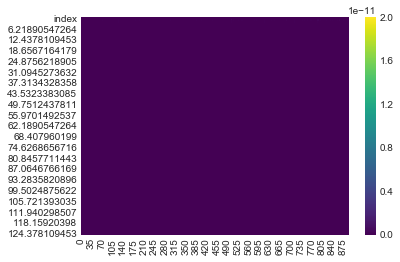

In [126]:
graph_fft(datasets_sujetos[1])

/Users/martinjedwabny/Github/CienciaDeDatos/py2/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


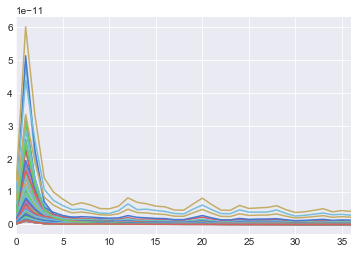

In [11]:
graph_potencias(datasetPrincipal)

In [25]:
del datasetPrincipal

In [26]:
def potencia_banda(low, high, potencias_promedio, frecuencias):
    # Thomas dice np.average
    return np.average(map(lambda x: x[0], ifilter(lambda x: x[1] >= low and x[1] < high, izip(potencias_promedio, frecuencias))))

def get_bandas_dict(dataset):
    potencias_promedio_by_electrode = []
    for i in range(electrodes_count(dataset)):
        potencias_promedio_by_electrode.append(potencias_promedio(i, dataset))
    potencias_promedio_total = [np.average([potencias_promedio_by_electrode[j][i] for j in range(len(potencias_promedio_by_electrode))]) for i in range(len(potencias_promedio_by_electrode[0]))]
    del potencias_promedio_by_electrode
    frecuencias = par_frecuencias_potencias_epoch(0,0, dataset)[0]
    res = {}
    res['delta'] = potencia_banda(0., 4.0, potencias_promedio_total, frecuencias)
    res['theta'] = potencia_banda(4.0, 8.0, potencias_promedio_total, frecuencias)
    res['alpha'] = potencia_banda(8.0, 13.0, potencias_promedio_total, frecuencias)
    res['beta'] = potencia_banda(13.0, 30., potencias_promedio_total, frecuencias)
    res['gamma'] = potencia_banda(30.0, 125., potencias_promedio_total, frecuencias)
    
    return res

In [31]:
bandas_frame_columns = ['delta','theta','alpha','beta','gamma','tipo']
bandas_frame = pd.DataFrame(data=[], columns=bandas_frame_columns)

for sujeto_str in dataset_sujetos_str[0:6]:
    dataset = scipy.io.loadmat('datos/{0}.mat'.format(sujeto_str))['data']
    bandas_dict = get_bandas_dict(dataset)
    if sujeto_str[0] == 'P':
        bandas_dict['tipo'] = 'normal'
    else:
        bandas_dict['tipo'] = 'disminuido'
    bandas_sujeto = pd.DataFrame(data=[bandas_dict], columns=bandas_frame_columns)
    bandas_frame = bandas_frame.append(bandas_sujeto)

In [35]:
print bandas_frame

          delta         theta         alpha          beta         gamma  \
0  6.563069e-12  1.246806e-12  4.485051e-13  1.983459e-13  1.604475e-13   
0  2.982860e-12  8.169761e-13  6.708537e-13  3.538571e-13  2.067432e-13   
0  1.272164e-11  3.368208e-12  5.829568e-13  3.194208e-13  1.822494e-13   
0  2.388813e-12  1.485615e-12  6.040987e-12  3.185578e-13  6.348191e-14   
0  1.386406e-11  1.829608e-12  5.376005e-13  1.080624e-13  6.090966e-14   
0  2.395525e-12  9.538994e-13  3.907879e-12  1.659524e-13  2.609784e-14   

         tipo  
0      normal  
0  disminuido  
0      normal  
0  disminuido  
0      normal  
0  disminuido  


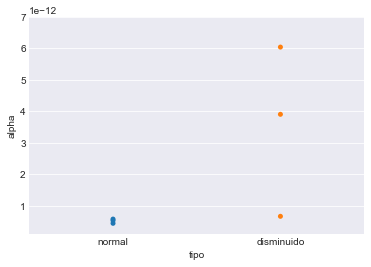

In [38]:
sns.stripplot(data=bandas_frame, y="alpha", x="tipo")
plt.ylim(1e-13, 7e-12)
plt.show()


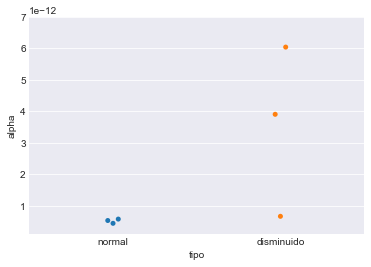

In [39]:
sns.swarmplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()